In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
# cd drive/MyDrive/IE7500_GroupB/Notebooks

In [3]:
# load necesary libraries
import numpy as np
import pandas as pd

In [4]:
dtypes_dict = {'headline': 'object',
               'url': 'object',
               'publisher': 'object',
               'stock': 'object',
               'tokens': 'object',
               'normalized_tokens': 'object',
               'filtered_tokens': 'object',
               'lemmas': 'object',
               'sentiment_score': 'float64',
               'Name': 'object',
               'Market Cap': 'float64',
               'Country': 'object',
               'IPO Year': 'float64',
               'Sector': 'object',
               'Industry': 'object',
               'year': 'int32',
               'month': 'int32',
               'day_of_week': 'int32',
               'sentiment_label': 'int64',
               'headline_length': 'int64',
               'word_count': 'int64',
               'Market_Cap_Category': 'object',
               'recommendation': 'object',
               'cap_Large': 'bool',
               'cap_Medium': 'bool',
               'cap_Mega': 'bool',
               'cap_Micro': 'bool',
               'cap_Nano': 'bool',
               'cap_Small': 'bool',
               'sector_Basic Materials': 'bool',
               'sector_Consumer Discretionary': 'bool',
               'sector_Consumer Staples': 'bool',
               'sector_Energy': 'bool',
               'sector_Finance': 'bool',
               'sector_Health Care': 'bool',
               'sector_Industrials': 'bool',
               'sector_Miscellaneous': 'bool',
               'sector_Real Estate': 'bool',
               'sector_Technology': 'bool',
               'sector_Telecommunications': 'bool',
               'sector_Utilities': 'bool', 'recommendation_label': 'int64',
               'publisher_label': 'int64', 'country_label': 'int64',
               'industry_label': 'int64'}

In [5]:
# load dataframes to use
df_main = pd.read_csv("saved_dfs/df_for_models.csv", dtype=dtypes_dict,
                      parse_dates=['date'])

In [6]:
df_main.head()

,headline,url,publisher,date,stock,tokens,normalized_tokens,filtered_tokens,lemmas,sentiment_score,...,sector_Industrials,sector_Miscellaneous,sector_Real Estate,sector_Technology,sector_Telecommunications,sector_Utilities,recommendation_label,publisher_label,country_label,industry_label
0,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01,A,"['Agilent', 'Technologies', 'Announces', 'Pric...","['agilent', 'technologies', 'announces', 'pric...","['agilent', 'technologies', 'announces', 'pric...","['agilent', 'technology', 'announces', 'pricin...",0.0000,...,True,False,False,False,False,False,1,4,45,18
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18,A,"['Agilent', '(', 'A', ')', 'Gears', 'Up', 'for...","['agilent', 'a', 'gears', 'up', 'for', 'q2', '...","['agilent', 'gears', 'q2', 'earnings', 'cards']","['agilent', 'gear', 'q2', 'earnings', 'card']",0.0000,...,True,False,False,False,False,False,1,16,45,18
2,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15,A,"['J.P.', 'Morgan', 'Asset', 'Management', 'Ann...","['morgan', 'asset', 'management', 'announces',...","['morgan', 'asset', 'management', 'announces',...","['morgan', 'asset', 'management', 'announces',...",0.3612,...,True,False,False,False,False,False,1,4,45,18
3,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15,A,"['Pershing', 'Square', 'Capital', 'Management'...","['pershing', 'square', 'capital', 'management'...","['pershing', 'square', 'capital', 'management'...","['pershing', 'square', 'capital', 'management'...",0.0000,...,True,False,False,False,False,False,1,4,45,18
4,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12,A,"['Agilent', 'Awards', 'Trilogy', 'Sciences', '...","['agilent', 'awards', 'trilogy', 'sciences', '...","['agilent', 'awards', 'trilogy', 'sciences', '...","['agilent', 'award', 'trilogy', 'science', 'go...",0.4588,...,True,False,False,False,False,False,1,4,45,18


# Goal 3: ML Trading Bot

## Method 1: XGBoost

In [7]:
!pip install xgboost

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Define features and target
features = ["sentiment_score", "publisher_label", "country_label", "industry_label",
            "sector_Industrials", "sector_Miscellaneous", "sector_Real Estate",
            "sector_Technology", "sector_Telecommunications", "sector_Utilities"]
target = "recommendation_label"

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_main[features], df_main[target], test_size=0.2, random_state=42
)


In [9]:
# Standardize numerical column (sentiment_score); passthrough others (already encoded)
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), ["sentiment_score"]),
    ("pass", "passthrough", features[1:])
])

# Build XGBoost pipeline
xgb_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(eval_metric="mlogloss", random_state=42))  # clean version without warnings
])


In [10]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation using F1 macro score
cv_scores = cross_val_score(xgb_pipeline, X_train, y_train, cv=5, scoring="f1_macro")
print(f"Cross-Validated F1 Score (XGBoost): {cv_scores.mean():.4f}")


Cross-Validated F1 Score (XGBoost): 0.9997


In [11]:
from sklearn.model_selection import GridSearchCV

# Parameter grid to tune
param_grid = {
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 6, 9],
    "clf__n_estimators": [100, 200]
}

# GridSearchCV
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_xgb_model = grid_search.best_estimator_
print(f"Best XGBoost Params: {grid_search.best_params_}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best XGBoost Params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 100}


In [12]:
# Predict and evaluate
y_pred = best_xgb_model.predict(X_test)
print("XGBoost Final Performance:")
print(classification_report(y_test, y_pred))


XGBoost Final Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37064
           1       1.00      1.00      1.00    317370
           2       1.00      1.00      1.00     14678

    accuracy                           1.00    369112
   macro avg       1.00      1.00      1.00    369112
weighted avg       1.00      1.00      1.00    369112



In [13]:
import joblib

# Save the model
joblib.dump(best_xgb_model, "xgboost_trading_bot.pkl")
print("Saved: xgboost_trading_bot.pkl")


Saved: xgboost_trading_bot.pkl


## Method 2: LightGBM

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# Define features and target
features = ["sentiment_score", "publisher_label", "country_label", "industry_label",
            "sector_Industrials", "sector_Miscellaneous", "sector_Real Estate",
            "sector_Technology", "sector_Telecommunications", "sector_Utilities"]
target = "recommendation_label"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_main[features], df_main[target], test_size=0.2, random_state=42
)


In [15]:
# Preprocessing: scale numerical features; passthrough categorical and binary sector features
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), ["sentiment_score"]),
    ("pass", "passthrough", features[1:])
])

# LightGBM classifier pipeline
lgbm_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", LGBMClassifier(objective="multiclass", num_class=3, random_state=42))
])


In [16]:
from sklearn.model_selection import cross_val_score

# 5-fold cross-validation with F1 macro score
cv_scores = cross_val_score(lgbm_pipeline, X_train, y_train, cv=5, scoring="f1_macro")
print(f"Cross-Validated F1 Score (LightGBM): {cv_scores.mean():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 1181157, number of used features: 10
[LightGBM] [Info] Start training from score -2.303574
[LightGBM] [Info] Start training from score -0.149741
[LightGBM] [Info] Start training from score -3.239907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 1181157, number of used features: 10
[LightGBM] [Info] Start training from score -2.303574
[LightGBM] [Info] Start training from score -0.149741
[LightGBM] [Info] Start training from score -3.239907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 461
[LightGBM] [Info] Number of data points in the train set: 1181158, number of used features: 10
[LightGBM] [Info] Start training from score -2.303574
[LightGBM] [Info] Start training from score -0.149741
[LightGBM] [Info] Start training from score -3.239886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 466
[LightGBM] [Info] Number of data points in the train set: 1181158, number of used features: 10
[LightGBM] [Info] Start training from score -2.303566
[LightGBM] [Info] Start training from score -0.149741
[LightGBM] [Info] Start training from score -3.239908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 469
[LightGBM] [Info] Number of data points in the train set: 1181158, number of used features: 10
[LightGBM] [Info] Start training from score -2.303574
[LightGBM] [Info] Start training from score -0.149740
[LightGBM] [Info] Start training from score -3.239908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cross-Validated F1 Score (LightGBM): 0.9998


In [17]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [5, 10, 15],
    "clf__n_estimators": [100, 200]
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(lgbm_pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract best model
best_lgbm_model = grid_search.best_estimator_
print(f"Best LightGBM Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 1476447, number of used features: 10
[LightGBM] [Info] Start training from score -2.303572
[LightGBM] [Info] Start training from score -0.149741
[LightGBM] [Info] Start training from score -3.239903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [18]:
# Predict on test data
y_pred = best_lgbm_model.predict(X_test)

# Print classification report
print("LightGBM Model Performance on Test Set:")
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Model Performance on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37064
           1       1.00      1.00      1.00    317370
           2       1.00      1.00      1.00     14678

    accuracy                           1.00    369112
   macro avg       1.00      1.00      1.00    369112
weighted avg       1.00      1.00      1.00    369112



In [19]:
import joblib

# Save the best LightGBM model to a file
joblib.dump(best_lgbm_model, "lightgbm_trading_bot.pkl")
print("Model saved as lightgbm_trading_bot.pkl")


Model saved as lightgbm_trading_bot.pkl


## Method 3: MLP (Multi-Layer Perceptron)

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Define feature set and target variable
features = ["sentiment_score", "publisher_label", "country_label", "industry_label",
            "sector_Industrials", "sector_Miscellaneous", "sector_Real Estate",
            "sector_Technology", "sector_Telecommunications", "sector_Utilities"]
target = "recommendation_label"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_main[features], df_main[target], test_size=0.2, random_state=42
)

# Preprocessing: scale sentiment_score, passthrough rest
preprocessor = ColumnTransformer([
    ("scale", StandardScaler(), ["sentiment_score"]),
    ("pass", "passthrough", features[1:])
])


In [12]:
# MLP classifier pipeline
mlp_pipeline = Pipeline([
    ("prep", preprocessor),
    ("clf", MLPClassifier(random_state=42, max_iter=300))
])

# Train the model on the full training set
mlp_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['sentiment_score']),
                                                 ('pass', 'passthrough',
                                                  ['publisher_label',
                                                   'country_label',
                                                   'industry_label',
                                                   'sector_Industrials',
                                                   'sector_Miscellaneous',
                                                   'sector_Real Estate',
                                                   'sector_Technology',
                                                   'sector_Telecommunications',
                                                   'sector_Utilities'])])),
                ('clf', MLPClassifier(max_iter=300, random_state=42))])

In [13]:
# Predict on the test set
y_pred_test = mlp_pipeline.predict(X_test)

# Classification report
print("Classification Report (MLP Model):")
print(classification_report(y_test, y_pred_test))

Classification Report (MLP Model):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37064
           1       1.00      0.99      1.00    317370
           2       0.92      1.00      0.96     14678

    accuracy                           1.00    369112
   macro avg       0.97      1.00      0.98    369112
weighted avg       1.00      1.00      1.00    369112



In [14]:
import joblib

# Save model to file
joblib.dump(mlp_pipeline, "mlp_trading_bot.pkl")
print("Model saved as mlp_trading_bot.pkl")


Model saved as mlp_trading_bot.pkl


## Method 4: Reinforcement Learning (DQN) for ML Trading Bot


In [28]:
!pip install stable-baselines3[extra] gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [29]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

# Features for the RL environment
features = ["sentiment_score", "publisher_label", "country_label", "industry_label",
            "sector_Industrials", "sector_Miscellaneous", "sector_Real Estate",
            "sector_Technology", "sector_Telecommunications", "sector_Utilities"]

# Prepare feature data
rl_df = df_main[features].fillna(0).reset_index(drop=True)


In [30]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.initial_balance = 1000.0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.n_steps = len(df)

        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)
        # Observations: all features (shape = number of columns)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(df.shape[1],), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        return self.df.iloc[self.current_step].values.astype(np.float32)

    def step(self, action):
        done = False
        current_price = self.df.iloc[self.current_step]["sentiment_score"] + 1  # Simulated price
        reward = 0

        # Execute Buy
        if action == 1 and self.balance >= current_price:
            self.shares_held += 1
            self.balance -= current_price
        # Execute Sell
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += current_price
            reward = current_price - 1  # Assume base cost = 1

        # Go to next step
        self.current_step += 1
        if self.current_step >= self.n_steps - 1:
            done = True

        obs = self.df.iloc[self.current_step].values.astype(np.float32)
        return obs, reward, done, {}

    def render(self, mode="human"):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}")


In [32]:
!pip install 'shimmy>=2.0'

In [33]:
# Wrap the custom environment using DummyVecEnv
env = DummyVecEnv([lambda: TradingEnv(rl_df)])


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [34]:
# Initialize and train the DQN agent
model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)


Using cpu device


In [35]:
obs = env.reset()
total_reward = 0

for _ in range(len(rl_df) - 1):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    if done:
        break

print(f"Total Reward from DQN Agent: {total_reward}")

Total Reward from DQN Agent: [20697.22]


In [36]:
# Save the model
model.save("dqn_trading_bot")
print("Model saved as dqn_trading_bot.zip")

Model saved as dqn_trading_bot.zip


## Method 5: LSTM for Time Series Forecasting

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [38]:
# Use sentiment_score as proxy for "price" or signal
data = df_main["sentiment_score"].fillna(0).values.reshape(-1, 1)

# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for supervised learning
def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

sequence_length = 10
X_seq, y_seq = create_sequences(scaled_data, sequence_length)

# Split into training and test sets (80/20)
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

In [39]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train LSTM model, use 5 epochs to save time
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 346s 7ms/step - loss: 0.0225 - val_loss: 0.0232
Epoch 2/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 370s 7ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 3/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 382s 7ms/step - loss: 0.0224 - val_loss: 0.0231
Epoch 4/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 344s 7ms/step - loss: 0.0224 - val_loss: 0.0232
Epoch 5/5
46139/46139 ━━━━━━━━━━━━━━━━━━━━ 337s 7ms/step - loss: 0.0224 - val_loss: 0.0232


In [42]:
# Predict on test data
y_pred = lstm_model.predict(X_test)

# Inverse scale predictions and ground truth
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"LSTM Test RMSE: {rmse:.4f}")

11535/11535 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step
LSTM Test RMSE: 0.2905


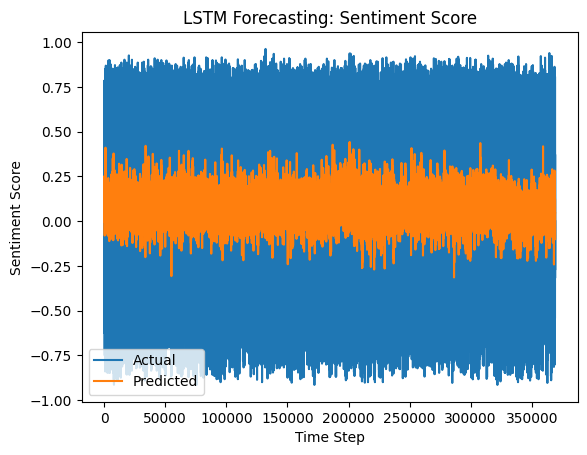

In [43]:
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title("LSTM Forecasting: Sentiment Score")
plt.xlabel("Time Step")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()